\# locally adaptive histogram equalization
\# update numpy nd.nditer

## Gamma

> In the early days, the relationship between the voltage and the resulting brightness was characterized by $\gamma$, since
the formula was roughly $B = V^\gamma$ where gamma is about $2.2$. To compensate for this effect, the electronics in the TV camera would pre-map the sensed luminance Y through an inverse gamma $Y' = Y^{\frac{1}{\gamma}}$ with a typical value of $\frac{1}{\gamma} = 0.45$. This is so-called __Gamma Correlation__. One of the side effects is that noise introduced during transmission is squashed in the dark regions, which corresponds to the more noise-sensitive region of the visual system.

It defines the relationship between a pixel's numerical value and its actual luminance. 
 ![luminance-receivedEnergy](dataset/gamma_chart1.png)

It's shown that we are more sensitive to the changes in dark tones. When a digital image is saved, it's therefore "gamma encoded" via $V_{out} = V_{in}^\gamma$ where $\gamma < 1$; So that twice the value in a file more closely corresponds to what we would perceive as being twice as bright. If we use a $\gamma > 1$, it's called decoding.

Since gamma encoding redistributes tonal levels closer to how our eyes perceive them, its gradient distributes the tones roughly evenly across the entire range ("perceptually uniform"). Notice how the linear encoding distribute an excess of bits to describe the brighter tones (where the camera is relatively more sensitive), and a shortage of bits to describe the darker tones (where the camera is relatively less sensitive).

<div style="background-color:rgb(55, 55, 55); color: white; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">

Original

![luminance-receivedEnergy](dataset/gamma_gradient3b.jpg)

Linear Encoded

![luminance-receivedEnergy](dataset/gamma_gradient2b.png)

Gamma Encoded

![luminance-receivedEnergy](dataset/gamma_gradient1b.png)
</div>

### Gamma Pipline

![gamma](dataset/gamma_pipline.png)

1. Image Gamma. This is applied when RAW data is converted into a standard JPEG or TIFF file. It redistributes native camera tonal levels into ones which are more perceptually uniform, thereby making the most efficient use of a given bit depth. If no color profile is embedded, then a standard gamma of 1/2.2 is usually assumed, that's why RAW image seems to be dark.

![gamma](dataset/Image_File_Gamma.png)

2. Display Gamma. It is used to compensate for a file's gamma — thereby ensuring that the image isn't unrealistically brightened when displayed on your screen. A higher display gamma results in a darker image with greater contrast.

3. System Gamma. It is also referred to as the "viewing gamma." For faithful reproduction of a scene, this should ideally be close to a straight line (gamma = 1.0). Sometimes, the system gamma is slightly greater than 1.0 in order to improve contrast. This can help compensate for limitations due to the dynamic range of a display device, or due to non-ideal viewing conditions and image flare. 

Monitor Calibration:
- In CRT Monitors, the native gamma of a CRT is coincidentally 2.5 — almost the inverse of our eyes. Values from a gamma-encoded file could therefore be sent straight to the screen and they would automatically be corrected and appear nearly OK. Only a small gamma correction of ~1/1.1 needs to be applied to achieve an overall display gamma of 2.2, which is usually already set by the manufacturer's default settings, but can also be set during .
- LCD monitors weren't so fortunate; ensuring an overall display gamma of 2.2 often requires substantial corrections, therefore a look-up table (LUT) required in order to ensure that input values are depicted using the intended display gamma.

In [32]:
import cv2

In [33]:
import numpy as np

In [34]:
img = cv2.imread('dataset/Orgrimmar.jpg')

In [35]:
from matplotlib import pyplot as plt

<img src="dataset/Orgrimmar.jpg" alt="Orgrimmar" style="width: 600px;"/>

A useful api to deal with gamma_adjusting is 
- `cv2.LUT(src, lut[, dst[, interpolation]])`
which means that for an int8 array, a look-up table transformation will be given.

In [36]:
# Create the look up table
lut = lambda gamma = 2.2: np.uint8([ (i/ 255.0) ** (1/gamma) * 255 for i in range(256)])

(-0.5, 1919.5, 1079.5, -0.5)

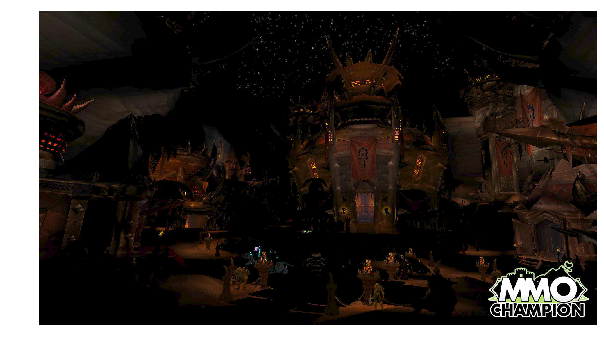

In [37]:
adjusted = cv2.LUT(img.astype(np.uint8), lut(1.8))
f, axis = plt.subplots(1, 1, figsize = (10, 10))
plt.imshow(cv2.cvtColor(adjusted.astype(np.uint8), cv2.COLOR_BGR2RGB))
axis.axis("off")

## Histogram equalization
> One approach is to look at the darkest and brightest pixel values in an image and map them to pure black and pure white. Another approach might be to find the average value in the image, push it towards middle gray, and expand the range. Histogram will give us such statistic infomation. Alternatively, we can also find an intensity mapping function f(I) such that the resulting histogram is flat. This approach is called histogram equalization. The trick to finding such a mapping is the same one that people use to generate random samples from a probability density function, which is to first compute the cumulative distribution function. 

$$c(I) = \frac{1}{N}\sum_{i = 0}^I h(i) = c(I- 1) + \frac{1}{N} h(I)$$

---

show that why $F(x)$ is uniformly distributed
We know that $f(x)$ is a $p.d.f.$, and $y = F(x)$ is a $c.d.f.$. Then we have 
$$x  = F ^ {-1} (y)$$
and 
$$\frac{dx}{dy} = (F^{-1})'(y) = \frac{1}{F'(x)} = \frac{1}{f(x)}$$
Then we have
$$\int f(x) dx = \int f(F^{-1}(y)) \frac{1}{f(x)} dy = \int 1 \cdot dy$$
so $g(Y)$ is uniformly distributed

---

In [38]:
imgHE = cv2.imread('dataset/test_HE.jpg')
B, G, R = cv2.split(imgHE)

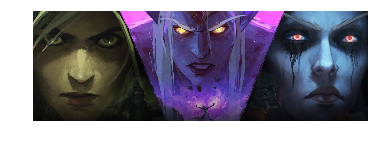

In [39]:
plt.axis("off")
plt.imshow(cv2.cvtColor(imgHE, cv2.COLOR_BGR2RGB))

In [40]:
def getHistogram(panel):
    nbin = 256
    h = np.zeros((nbin, ), dtype = int)
    for x in np.nditer(panel):
        h[x] += 1
    return h

def getCDF(h, size):
    hc = h.copy()
    for i in range(1, h.shape[0]):
        hc[i] = hc[i - 1] + hc[i]
    return (hc /size * 255).astype(np.uint8)


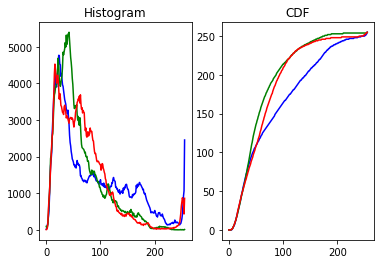

In [41]:
bh = getHistogram(B)
gh = getHistogram(G)
rh = getHistogram(R)
bc = getCDF(bh, B.size)
gc = getCDF(gh, G.size)
rc = getCDF(rh, R.size)
f, axarr = plt.subplots(1, 2)
axarr[0].set_title('Histogram')
axarr[0].plot(bh, c = 'b') 
axarr[0].plot(gh, c = 'g')
axarr[0].plot(rh, c = 'r')

axarr[1].set_title('CDF')
axarr[1].plot(bc, c = 'b') 
axarr[1].plot(gc, c = 'g')
axarr[1].plot(rc, c = 'r')

### Full histogram equalization

We could apply $f(I) = c(I)$ to the original image. 

In [42]:
def fullHE(panel, CDF):
    panelc = panel.copy()
    for i in range(panelc.shape[0]):
        for j in range(panelc.shape[1]):
            panelc[i][j] = CDF[panel[i][j]]
    return panelc

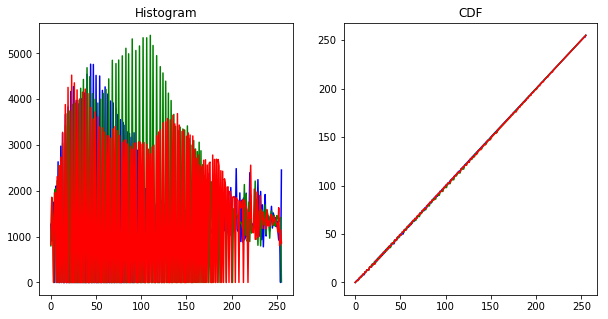

In [43]:
bfullHE = fullHE(B, bc)
gfullHE = fullHE(G, gc)
rfullHE = fullHE(R, rc)

bhf = getHistogram(bfullHE)
ghf = getHistogram(gfullHE)
rhf = getHistogram(rfullHE)

bcf = getCDF(bhf, B.size)
gcf = getCDF(ghf, G.size)
rcf = getCDF(rhf, R.size)

f, axarr = plt.subplots(1, 2, figsize = (10, 5))
axarr[0].set_title('Histogram')
axarr[0].plot(bhf, c = 'b') 
axarr[0].plot(ghf, c = 'g')
axarr[0].plot(rhf, c = 'r')

axarr[1].set_title('CDF')
axarr[1].plot(bcf, c = 'b') 
axarr[1].plot(gcf, c = 'g')
axarr[1].plot(rcf, c = 'r')

### Why there're SUCH AMOUNT OF zeros???

In [44]:
print(bhf[bhf == 0].shape)

(70,)


##### It's shown that not every value could be found in cdf. That's because inside the function, we just simply floor floats to integer. Let's try to improve this.

In [45]:
def getCDF_new(h, size):
    hc = h.copy()
    divider = size / 255.0
    for i in range(1, h.shape[0]):
        hc[i] = hc[i - 1] + hc[i]
        if hc[i - 1] / divider - hc[i - 1] // divider > 0.5:
            hc[i - 1] = hc[i - 1] // divider + 1
        else:
            hc[i - 1] = hc[i - 1] // divider
    hc[255] = 255
    return hc


In [46]:
bcn = getCDF_new(bh, B.size)
gcn = getCDF_new(gh, G.size)
rcn = getCDF_new(rh, R.size)

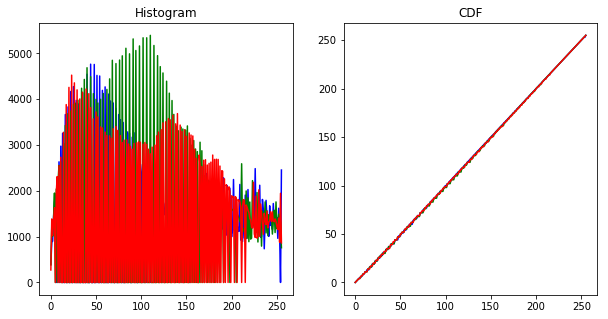

In [47]:
bfullHE_n = fullHE(B, bcn)
gfullHE_n = fullHE(G, gcn)
rfullHE_n = fullHE(R, rcn)

bhf_n = getHistogram(bfullHE_n)
ghf_n = getHistogram(gfullHE_n)
rhf_n = getHistogram(rfullHE_n)

bcf_n = getCDF_new(bhf_n, B.size)
gcf_n = getCDF_new(ghf_n, G.size)
rcf_n = getCDF_new(rhf_n, R.size)

f, axarr = plt.subplots(1, 2, figsize = (10, 5))
axarr[0].set_title('Histogram')
axarr[0].plot(bhf_n, c = 'b') 
axarr[0].plot(ghf_n, c = 'g')
axarr[0].plot(rhf_n, c = 'r')

axarr[1].set_title('CDF')
axarr[1].plot(bcf_n, c = 'b') 
axarr[1].plot(gcf_n, c = 'g')
axarr[1].plot(rcf_n, c = 'r')

And below is our result.

In [48]:
print(bcn)

[  0   0   0   0   1   1   2   3   4   5   7   9  11  13  16  19  22  25
  28  31  34  37  40  44  48  51  54  57  60  64  66  69  72  75  77  80
  83  85  87  90  92  94  97  99 100 102 104 105 107 108 109 111 112 113
 114 116 117 118 120 121 122 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 146 147 148 149 150 151 152 153
 155 156 157 158 159 160 160 161 162 163 164 165 166 167 168 169 170 171
 172 172 173 174 175 176 177 178 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 191 192 193 194 195 195 196 197 198 198 199 200 201 202
 202 203 204 205 206 207 208 209 209 210 211 211 212 213 213 214 215 215
 216 217 218 218 219 220 221 222 223 224 225 226 226 227 228 229 230 231
 231 232 233 234 234 235 235 236 237 237 238 238 238 239 239 239 240 240
 240 241 241 242 242 242 242 243 243 243 244 244 244 245 245 245 246 246
 246 246 246 247 247 247 247 247 247 247 247 248 248 248 248 248 248 248
 248 249 249 249 249 249 249 250 250 250 250 250 25

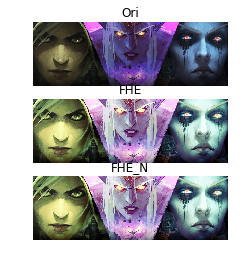

In [49]:
f, axarr = plt.subplots( 3, 1)
imgHEF = cv2.merge((bfullHE, gfullHE, rfullHE))
imgHEF_N = cv2.merge((bfullHE_n, gfullHE_n, rfullHE_n))
axarr[0].set_title("Ori")
axarr[0].axis("off")
axarr[0].imshow(cv2.cvtColor(imgHE, cv2.COLOR_BGR2RGB))
axarr[1].set_title("FHE")
axarr[1].axis("off")
axarr[1].imshow(cv2.cvtColor(imgHEF, cv2.COLOR_BGR2RGB))
axarr[2].set_title("FHE_N")
axarr[2].axis("off")
axarr[2].imshow(cv2.cvtColor(imgHEF_N, cv2.COLOR_BGR2RGB))

In [50]:
print(bc)

[  0   0   0   0   0   0   1   2   3   5   6   8  11  13  16  19  22  25
  28  31  34  37  40  44  47  50  54  57  60  63  66  69  72  74  77  80
  82  85  87  89  92  94  96  98 100 101 103 105 106 107 109 110 111 113
 114 115 117 118 119 121 122 123 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 167 168 169 170
 171 172 173 174 175 175 176 177 178 179 180 181 181 182 183 184 185 186
 187 188 189 190 191 192 193 193 194 195 196 196 197 198 199 199 200 201
 202 203 204 205 205 206 207 208 209 209 210 211 211 212 213 213 214 215
 216 216 217 218 219 220 220 221 222 223 224 225 226 227 228 229 229 230
 231 232 232 233 234 234 235 236 236 237 237 237 238 238 239 239 239 240
 240 240 241 241 241 242 242 242 243 243 243 244 244 244 244 245 245 245
 246 246 246 246 246 246 247 247 247 247 247 247 247 247 247 248 248 248
 248 248 248 248 249 249 249 249 249 249 250 250 25

##### It's sadly that I failed to improve it.... there seems to be no differences.....

### Partial histogram equalization

One way to compensate for this is to only partially compensate for the histogram unevenness, e.g., by using a mapping function $f(I) = \alpha c(I) + (1-\alpha)I$, which is a linear blend between the cumulative distribution function and the identity transform (a straight line).

In [51]:
def partialHE(panel, CDF, alpha = 0.5):
    ratio4I = 1 - alpha
    panelc = panel.copy()
    for i in range(panelc.shape[0]):
        for j in range(panelc.shape[1]):
            panelc[i][j] = alpha * CDF[panelc[i][j]] + ratio4I * panelc[i][j]
    return panelc

Then similarly,

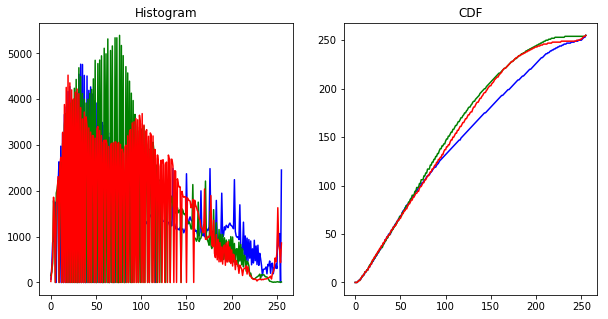

In [52]:
bpHE = partialHE(B, bc)
gpHE = partialHE(G, gc)
rpHE = partialHE(R, rc)

bhp = getHistogram(bpHE)
ghp = getHistogram(gpHE)
rhp = getHistogram(rpHE)

bcp = getCDF(bhp, B.size)
gcp = getCDF(ghp, G.size)
rcp = getCDF(rhp, R.size)

f, axarr = plt.subplots(1, 2, figsize = (10, 5))
axarr[0].set_title('Histogram')
axarr[0].plot(bhp, c = 'b') 
axarr[0].plot(ghp, c = 'g')
axarr[0].plot(rhp, c = 'r')

axarr[1].set_title('CDF')
axarr[1].plot(bcp, c = 'b') 
axarr[1].plot(gcp, c = 'g')
axarr[1].plot(rcp, c = 'r')

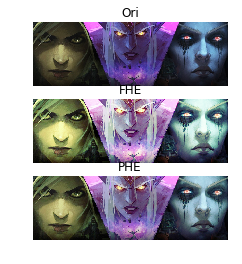

In [53]:
f, axarr = plt.subplots( 3, 1)
imgHEF = cv2.merge((bfullHE, gfullHE, rfullHE))
imgHEP = cv2.merge((bpHE, gpHE, rpHE))
axarr[0].set_title("Ori")
axarr[0].axis("off")
axarr[0].imshow(cv2.cvtColor(imgHE, cv2.COLOR_BGR2RGB))
axarr[1].set_title("FHE")
axarr[1].axis("off")
axarr[1].imshow(cv2.cvtColor(imgHEF, cv2.COLOR_BGR2RGB))
axarr[2].set_title("PHE")
axarr[2].axis("off")
axarr[2].imshow(cv2.cvtColor(imgHEP, cv2.COLOR_BGR2RGB))

In [54]:
print(bhf)

[1270  902 1424 1751    0 1909 2110    0 2633    0    0 2975    0 3257
    0    0 3666    0    0 3832    0    0 4169    0    0 4275    0    0
 3974    0    0 3899    0    0 4010    0    0 4137    0    0 4545    0
    0    0 4765    0    0 4759    0    0 4520    0    0    0 4507    0
    0 4193    0    0 4269    0    0 4113    0    0 3961    0    0 3918
    0    0 3797    0 3665    0    0 3555    0    0 3492    0 3432    0
    0 3287    0 3254    0 3171    0    0 3267    0 3059    0 2888    0
 2582    0 2391 2292    0 2142    0 2049 1936 1900    0 1854 1772 1782
    0 1716 1761 1689    0 1801 1894 1799    0 1816 1762 1770    0 1709
 1478 1486 1419 1402 1351 1352 1316 1357 1351 1349 1306 1327 1284 1342
 1379 1420 1453 1480 1471 1516 1526 1498    0 1570 1583 1501 1450 1501
 1441 1388 1342 1333 1335 1320 1268 1252 1309 1311 1370 1236 1240 2487
 1198 1278 1170 1216 1162 1167 1144 2385 1163 1168 1084 1132 1186 2373
 1287 1279 1380 1431 1362 1342 1321 1166 1167 1118 1132 2096 1021 1095
 2000 

In [55]:
print (bhf[bhf == 0].shape)

(70,)


## Useful APIs supported in matplotlib and opencv

Again, it's time to learn how to use the existing apis.

### Matplotlib
`matplotlib.pyplot.hist(x, bins=None, range=None, density=None, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, normed=None, *, data=None, **kwargs)`
it's a quite customizable api as the large amount of parameter you can pass.. It can draw both pdf and cdf. Let's see the example.

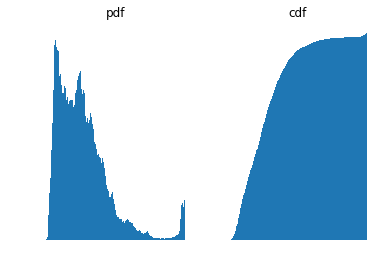

In [56]:
f, axarr = plt.subplots( 1, 2)
axarr[0].set_title("pdf")
axarr[0].axis("off")
axarr[0].hist(R.ravel(),256,[0,256]);
axarr[1].set_title("cdf")
axarr[1].axis("off")
axarr[1].hist(R.ravel(),256,[0,256], cumulative = True);
# seems like semi-colon is a must to silent the plt.hist() LOL

### OpenCV

`cv2.calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]])`
`cv2.equalizeHist(src)`
EqualizeHist still need to be done per channel, and CV_8UC1 means there's only a single channel

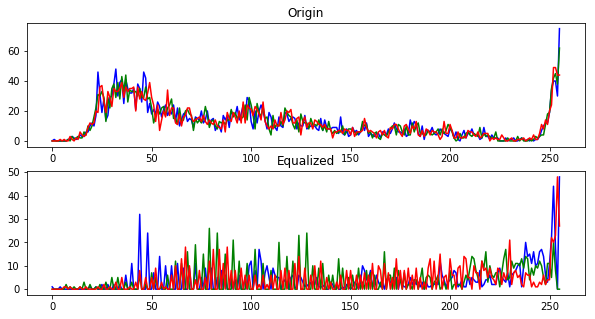

In [57]:
histSize = 256
histRange = (0, 256) # the upper boundary is exclusive
accumulate = False
# cal hist
b_hist = cv2.calcHist(imgHE, [0], None, [histSize], histRange, accumulate=accumulate)
g_hist = cv2.calcHist(imgHE, [1], None, [histSize], histRange, accumulate=accumulate)
r_hist = cv2.calcHist(imgHE, [2], None, [histSize], histRange, accumulate=accumulate)
# equalize per channel
b_cv = cv2.equalizeHist(imgHE[:,:, 0])
g_cv = cv2.equalizeHist(imgHE[:,:, 1])
r_cv = cv2.equalizeHist(imgHE[:,:, 2])
# call hist
b_histE = cv2.calcHist(b_cv, [0], None, [histSize], histRange, accumulate=accumulate)
g_histE = cv2.calcHist(g_cv, [0], None, [histSize], histRange, accumulate=accumulate)
r_histE = cv2.calcHist(r_cv, [0], None, [histSize], histRange, accumulate=accumulate)
#draw hist
f, axarr = plt.subplots(2, 1, figsize = (10, 5))
axarr[0].set_title('Origin')
axarr[0].plot(b_hist, c = 'b') 
axarr[0].plot(g_hist, c = 'g')
axarr[0].plot(r_hist, c = 'r')

axarr[1].set_title('Equalized')
axarr[1].plot(b_histE, c = 'b') 
axarr[1].plot(g_histE, c = 'g')
axarr[1].plot(r_histE, c = 'r')

#### Compared with ours:

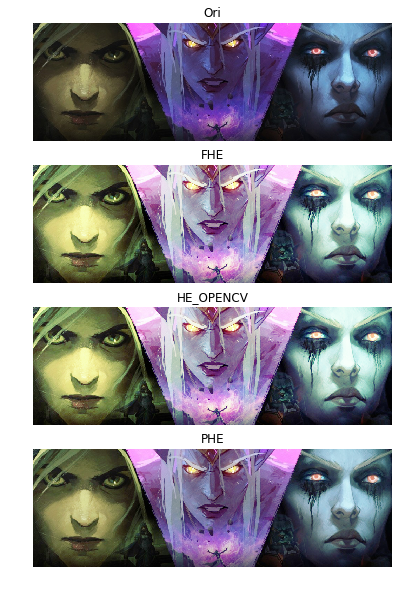

In [58]:
f, axarr = plt.subplots( 4, 1, figsize = (7, 10))
imgHEF = cv2.merge((bfullHE, gfullHE, rfullHE))
imgHEP = cv2.merge((bpHE, gpHE, rpHE))
imgHE_CV = cv2.merge((b_cv, g_cv, r_cv))
axarr[0].set_title("Ori")
axarr[0].axis("off")
axarr[0].imshow(cv2.cvtColor(imgHE, cv2.COLOR_BGR2RGB))
axarr[1].set_title("FHE")
axarr[1].axis("off")
axarr[1].imshow(cv2.cvtColor(imgHEF, cv2.COLOR_BGR2RGB))
axarr[3].set_title("PHE")
axarr[3].axis("off")
axarr[3].imshow(cv2.cvtColor(imgHEP, cv2.COLOR_BGR2RGB))
axarr[2].set_title("HE_OPENCV")
axarr[2].axis("off")
axarr[2].imshow(cv2.cvtColor(imgHE_CV, cv2.COLOR_BGR2RGB))

Numpy

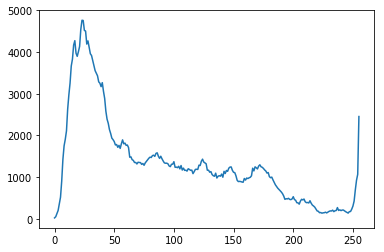

In [59]:
hist,bins = np.histogram(imgHE[:, :, 0].ravel(),256,[0,256])
#which is around 10X faster
#hist = np.bincount(imgHE[:,:,0].ravel(),minlength=256)
plt.plot(hist)

#### Exercise: Random Lighting

In [60]:
def random_lighting(img, intensity = 50):
    temp = img.copy()
    value = np.random.randint(intensity * -1, intensity, size=(3,))
    b, g, r = cv2.split(img)

    if value[0] < 0: 
        lim = - value[0]
        b[ b <= lim] = 0
        b[ b > lim] = b[ b > lim] + value[0]
    elif value[0] > 0:
        lim = 255 - value[0]
        b[ b >= lim] = 255
        b[ b < lim] = b[ b < lim] + value[0]
        
    if value[1] < 0: 
        lim = - value[1]
        g[ g <= lim] = 0
        g[ g > lim] = g[ g > lim] + value[1]
    elif value[1] > 0:
        lim = 255 - value[1]
        g[ g >= lim] = 255
        g[ g < lim] = g[ g < lim] + value[1]
    
    if value[2] < 0: 
        lim = - value[2]
        r[ r <= lim] = 0
        r[ r > lim] = r[ r > lim] + value[2]
    elif value[2] > 0:
        lim = 255 - value[2]
        r[ r >= lim] = 255
        r[ r < lim] = r[ r < lim] + value[2]
        
    return cv2.merge((b, g, r))

(-0.5, 1919.5, 1079.5, -0.5)

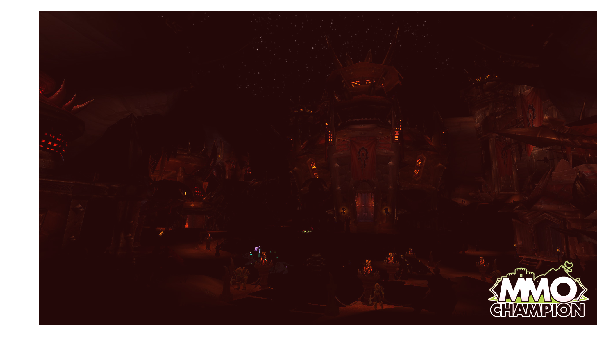

In [70]:
f, axis = plt.subplots(1, 1, figsize = (10, 10))
plt.imshow(cv2.cvtColor(random_lighting(img).astype(np.uint8), cv2.COLOR_BGR2RGB))
axis.axis("off")